## Import libraries

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import pylab

from scipy import stats

from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

## Loading the data 

In [70]:
concrete_df = pd.read_excel("Concrete_Data.xls")
concrete_df

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


In [71]:
# renaming column names
column_names = {'Cement (component 1)(kg in a m^3 mixture)':'Cement',
               'Blast Furnace Slag (component 2)(kg in a m^3 mixture)':'Blast Furnace',
               'Fly Ash (component 3)(kg in a m^3 mixture)':'Fly Ash',
               'Water  (component 4)(kg in a m^3 mixture)':'Water',
               'Superplasticizer (component 5)(kg in a m^3 mixture)':'Superplasticizer',
               'Coarse Aggregate  (component 6)(kg in a m^3 mixture)':'Coarse Aggregate',
               'Fine Aggregate (component 7)(kg in a m^3 mixture)':'Fine Aggregate',
               'Age (day)':'Age',
               'Concrete compressive strength(MPa, megapascals) ':'Concrete Strength'}
concrete_df = concrete_df.rename(columns=column_names)
concrete_df.head(20)

,Cement,Blast Furnace,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.029847
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.698299
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.447770
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.854291
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.289790


In [72]:
# check for nulls
display(concrete_df.isnull().any())

Cement               False
Blast Furnace        False
Fly Ash              False
Water                False
Superplasticizer     False
Coarse Aggregate     False
Fine Aggregate       False
Age                  False
Concrete Strength    False
dtype: bool

In [73]:
# check if dataframe is empty
if concrete_df.empty == True:
    print('DataFrame is empty')
else:
    print('DataFrame is not empty')

DataFrame is not empty




## Assumptions of Multiple Regression
    1. Linear relationship between the dependent and the independent variables
    2. Normally distributed 
    3. No or little multicollinearity (ie multiple variables should not be saying the same thing)
    4. No auto correlation of the residuals (should be random)
    5. Homoscedasticity (error terms should be constant)
    


## Checking for outliers

In [75]:
conc_desc_df = concrete_df.describe()
conc_desc_df

,Cement,Blast Furnace,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


In [76]:
# adding standard deviation metrics
conc_desc_df.loc['+3_std'] = conc_desc_df.loc['mean'] + (conc_desc_df.loc['std'] * 3)
conc_desc_df.loc['-3_std'] = conc_desc_df.loc['mean'] - (conc_desc_df.loc['std'] * 3)
conc_desc_df

,Cement,Blast Furnace,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225
+3_std,594.687056,332.732796,246.176544,245.633060,24.123587,1206.180047,1014.105166,235.171871,85.934873
-3_std,-32.355794,-184.941825,-137.802272,117.499658,-11.717363,739.657138,533.052601,-143.847599,-14.299202


In [77]:
# removing outliers
conc_remove_df = concrete_df[(np.abs(stats.zscore(concrete_df)) < 3).all(axis=1)]
# showing what rows that were removed
concrete_df.index.difference(conc_remove_df.index)

Int64Index([  2,   3,   4,   6,  12,  17,  24,  25,  26,  30,  31,  33,  34,
             35,  41,  42,  56,  60,  61,  63,  65,  66,  76,  79,  99, 102,
            122, 125, 145, 148, 168, 171, 553, 559, 571, 584, 604, 610, 616,
            620, 622, 756, 769, 792, 798, 814, 820, 873, 936],
           dtype='int64')



**49** rows are showing extreme values and are thus removed. 



In [80]:
concrete_df = conc_remove_df
concrete_df

,Cement,Blast Furnace,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.029847
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.447770
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.854291
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


## Checking for multicollinearity

In [81]:
# Method 1: printing out the correlation matrix of the dataframe
corr = concrete_df.corr()
display(corr)

,Cement,Blast Furnace,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete Strength
Cement,1.000000,-0.266304,-0.389627,-0.071275,0.030752,-0.092017,-0.237045,0.030070,0.485174
Blast Furnace,-0.266304,1.000000,-0.334005,0.105989,0.067749,-0.293014,-0.277038,-0.051424,0.149045
Fly Ash,-0.389627,-0.334005,1.000000,-0.256198,0.430177,-0.027443,0.059906,-0.054424,-0.081537
Water,-0.071275,0.105989,-0.256198,1.000000,-0.642098,-0.202212,-0.400538,0.115483,-0.327813
Superplasticizer,0.030752,0.067749,0.430177,-0.642098,1.000000,-0.240009,0.163262,-0.080850,0.384036
Coarse Aggregate,-0.092017,-0.293014,-0.027443,-0.202212,-0.240009,1.000000,-0.187842,0.022298,-0.158345
Fine Aggregate,-0.237045,-0.277038,0.059906,-0.400538,0.163262,-0.187842,1.000000,-0.036373,-0.162673
Age,0.030070,-0.051424,-0.054424,0.115483,-0.080850,0.022298,-0.036373,1.000000,0.432877
Concrete Strength,0.485174,0.149045,-0.081537,-0.327813,0.384036,-0.158345,-0.162673,0.432877,1.000000


The matrix shows a somewhat high negative correlation between _**Water**_ and _**Superplasticizer**_

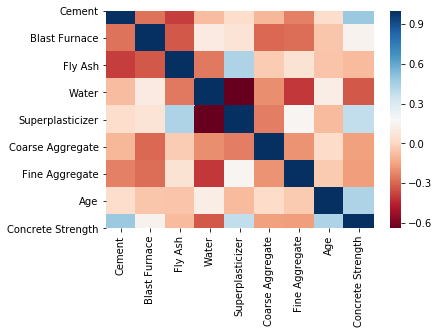

In [82]:
# Method 2: ploting heatmap to Visualize multicollinearity
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

The heatmap shows a correlation between _**Water**_ - _**Superplasticizer**_  and _**Water**_ - _**Fine Aggregate**_

In [83]:
# Method 3: removing Water, Superplasticizer and Fine Aggregate from the model
concrete_df = concrete_df.drop(['Water', 'Superplasticizer', 'Fine Aggregate'], axis=1)
concrete_df.head()


,Cement,Blast Furnace,Fly Ash,Coarse Aggregate,Age,Concrete Strength
0,540.0,0.0,0.0,1040.0,28,79.986111
1,540.0,0.0,0.0,1055.0,28,61.887366
5,266.0,114.0,0.0,932.0,90,47.029847
7,380.0,95.0,0.0,932.0,28,36.447770
8,266.0,114.0,0.0,932.0,28,45.854291


## Building the model

In [84]:
# define inpt variables and output variable
X = concrete_df.drop('Concrete Strength', axis = 1)
Y = concrete_df[['Concrete Strength']]

# split dataset into training and testing portion
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 1)

regression_model = LinearRegression()

# fitting the model
regression_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Exploring the output

In [87]:
# intercept 
intercept = regression_model.intercept_[0]
intercept

-36.5098687678842

In [94]:
# coefficient
coef = regression_model.coef_[0]
coef

array([0.12986006, 0.10496503, 0.11268796, 0.01421186, 0.21771982])

In [97]:
# printing the intercept and coefficient
print("The incercept for the model is {:.4}".format(intercept))
print('-'*50)

for c in zip(X.columns, coef):
    print("The Coefficient for {} is {:.2}".format(c[0],c[1]))

The incercept for the model is -36.51
--------------------------------------------------
The Coefficient for Cement is 0.13
The Coefficient for Blast Furnace is 0.1
The Coefficient for Fly Ash is 0.11
The Coefficient for Coarse Aggregate is 0.014
The Coefficient for Age is 0.22


## Interpretation

If all the variables are equal to zero, then the **Concrete Strength** would be **-36.51%**. Looking at **Age** while holding all the other independent variables constant, then 1 unit in **Age** would lead to **0.22%** increase in **Concrete Strength**.

## Equation

   Concrete Strength = **-36.51** + **0.13***Cement + **0.1***Blast Furnace + **0.11***Fly Ash + **0.014***Coarse Aggregate + **0.22***Age

## Predictions

In [98]:
# get multiple predictions
conc_pred = regression_model.predict(X_test)
conc_pred[:10]

array([[40.42182561],
       [37.68130183],
       [32.89714671],
       [40.93181249],
       [39.15432598],
       [66.38801551],
       [51.49682071],
       [41.99587066],
       [40.23945244],
       [34.07264385]])